In [ ]:
# --- Load My Functions ---
# Put the file name functions.py under folder
import functions
from functions import *

import GPT_function
from GPT_function import *

In [ ]:
# Library

import torch
import math
import re
import numpy as np
import pandas as pd
from torch.distributions import Laplace

from transformers import AutoTokenizer
from transformers import AutoModel
from transformers import AutoModelForCausalLM
from transformers import GPT2LMHeadModel

from datasets import load_dataset
from sentence_transformers import SentenceTransformer, util
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from scipy.stats import vonmises_fisher
import torch.nn.functional as F

from typing import Dict, List, Optional

from openai import OpenAI

from collections import Counter

# from rouge_score import rouge_scorer
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# --- Load tokenizer and GPT-2 model ---
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2", output_hidden_states=True)
embedding_table = model.get_input_embeddings().weight.detach()
if tokenizer.pad_token_id is None:
    tokenizer.pad_token = tokenizer.eos_token
model.eval()

# Base tokenizer pad fix (optional)
if getattr(tokenizer, "pad_token_id", None) is None and getattr(tokenizer, "eos_token", None) is not None:
    tokenizer.pad_token = tokenizer.eos_token

# Load a light GPT-2 model
gpt2_tok = AutoTokenizer.from_pretrained("distilgpt2")
if gpt2_tok.pad_token is None:
    gpt2_tok.pad_token = gpt2_tok.eos_token
gpt2_model = AutoModelForCausalLM.from_pretrained("distilgpt2").to(
    "cuda" if torch.cuda.is_available() else "cpu"
).eval()

# --- Extract embedding table ---
# Normalize embedding table for search
norm_embedding_table = torch.nn.functional.normalize(embedding_table, dim=1)

In [ ]:
# --- load all STAMP_Polar dataset ---

csv_files = [
    "squad_stamp_polar_tau_0.3.csv",
    "squad_stamp_polar_tau_0.4.csv",
    "squad_stamp_polar_tau_0.5.csv",
    "squad_stamp_polar_tau_0.6.csv",
    "squad_stamp_polar_tau_0.7.csv",
]

dataframes = {}

for file in csv_files:
    df_name = file.replace(".csv", "")
    dataframes[df_name] = pd.read_csv(file)


In [ ]:
# Get the answers

def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        return re.sub(r'[^\w\s]', '', text)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

def get_tokens(s):
    if not s: return []
    return normalize_answer(s).split()

def compute_f1(prediction, truth):
    pred_tokens = get_tokens(prediction)
    truth_tokens = get_tokens(truth)

    # if either is empty, return 1 if both are empty, 0 otherwise
    if not pred_tokens and not truth_tokens:
        return 1.0
    if not pred_tokens or not truth_tokens:
        return 0.0

    common_tokens = Counter(pred_tokens) & Counter(truth_tokens)
    num_common = sum(common_tokens.values())

    if num_common == 0:
        return 0.0

    precision = num_common / len(pred_tokens)
    recall = num_common / len(truth_tokens)

    return (2 * precision * recall) / (precision + recall)

def evaluate_answer(predicted_answer: str, true_answers: list[str]):
    """
    Evaluates a predicted answer against a list of true answers using F1 score and exact match.

    Args:
        predicted_answer: The generated answer string.
        true_answers: A list of true answer strings.

    Returns:
        A tuple containing:
            - The maximum F1 score achieved against any of the true answers.
            - A boolean indicating whether an exact match was found against any of the true answers.
    """
    max_f1 = 0.0
    exact_match = False

    normalized_prediction = normalize_answer(predicted_answer)

    for true_answer in true_answers:
        normalized_true = normalize_answer(true_answer)

        # Exact Match
        if normalized_prediction == normalized_true:
            exact_match = True

        # F1 Score
        f1 = compute_f1(predicted_answer, true_answer)
        max_f1 = max(max_f1, f1)

    return max_f1, exact_match


def calculate_cosine_similarity(prediction: str, truths: list[str], model) -> float:
    """
    Calculates the cosine similarity between the prediction and each true answer
    using Sentence-BERT embeddings and returns the maximum similarity.
    """
    if not prediction or not truths:
        return 0.0

    # Encode the prediction
    prediction_embedding = model.encode(prediction, convert_to_tensor=True)

    max_similarity = 0.0
    for truth in truths:
        if not truth:
            continue
        # Encode the true answer
        truth_embedding = model.encode(truth, convert_to_tensor=True)

        # Calculate cosine similarity
        similarity = util.pytorch_cos_sim(prediction_embedding, truth_embedding).item()
        max_similarity = max(max_similarity, similarity)

    return max_similarity


In [ ]:
# Initialize Sentence Transformer model
model_sentence = SentenceTransformer('all-MiniLM-L6-v2')

In [ ]:
num_rounds = 3
all_results = []

for round_num in range(num_rounds):
    print(f"--- Starting Round {round_num + 1}/{num_rounds} ---")
    results_list = []

    for df_name, df in dataframes.items():
        print(f"Processing DataFrame: {df_name}")
        for index, row in df.iterrows():
            question = row["question"]
            true_answers = eval(row["answers"]) # Assuming 'answers' is stored as a string representation of a list
            privatized_context = row["privatized_context"]
            repaired_context = row["repaired_context"]

            # Generate answer for privatized context
            try:
                response_privatized = client.chat.completions.create(
                    model="gpt-4o-mini",
                    messages=[
                        {"role": "system", "content": "You are a helpful assistant that answers questions based on the provided context. Limit your answer to one word."},
                        {"role": "user", "content": f"Context: {privatized_context}\nQuestion: {question}"}
                    ],
                    temperature=0.2,
                    max_tokens=5, # Limit response to one word, but just in case
                )
                answer_privatized = response_privatized.choices[0].message.content.strip()
            except Exception as e:
                print(f"Error generating answer for privatized context: {e}")
                answer_privatized = ""


            # Generate answer for repaired context
            try:
                response_repaired = client.chat.completions.create(
                    model="gpt-4o-mini",
                    messages=[
                        {"role": "system", "content": "You are a helpful assistant that answers questions based on the provided context. Limit your answer to one word."},
                        {"role": "user", "content": f"Context: {repaired_context}\nQuestion: {question}"}
                    ],
                    temperature=0.2,
                    max_tokens=5, # Limit response to one word, but just in case
                )
                answer_repaired = response_repaired.choices[0].message.content.strip()
            except Exception as e:
                print(f"Error generating answer for repaired context: {e}")
                answer_repaired = ""


            # Evaluate answers (F1 and EM already calculated)
            f1_privatized, em_privatized = evaluate_answer(answer_privatized, true_answers)
            f1_repaired, em_repaired = evaluate_answer(answer_repaired, true_answers)

            # Calculate Cosine Similarity

            cosine_privatized = calculate_cosine_similarity(answer_privatized, true_answers, model_sentence)
            cosine_repaired = calculate_cosine_similarity(answer_repaired, true_answers, model_sentence)

            results_list.append({
                "dataframe": df_name,
                "question": question,
                "true_answers": true_answers,
                "answer_privatized": answer_privatized,
                "f1_privatized": f1_privatized,
                "em_privatized": em_privatized,
                "cosine_privatized": cosine_privatized,
                "answer_repaired": answer_repaired,
                "f1_repaired": f1_repaired,
                "em_repaired": em_repaired,
                "cosine_repaired": cosine_repaired,
            })
    # Convert results list to DataFrame for the current round
    df_round_results = pd.DataFrame(results_list)
    all_results.append(df_round_results)

# The list 'all_results' now contains a DataFrame for each round
print(f"\nFinished {num_rounds} rounds of evaluation.")
# You can now proceed to aggregate across the dataframes in all_results

In [ ]:
# Load the combined results from the CSV file
df_all_results_combined = pd.read_csv("evaluation_results_all_rounds.csv")

In [ ]:
# Concatenate all results DataFrames into a single DataFrame
df_all_results_combined = pd.concat(all_results, ignore_index=True)

# Save the combined DataFrame to a CSV file
csv_output_path = "evaluation_results_all_rounds.csv"
df_all_results_combined.to_csv(csv_output_path, index=False)

print(f"All evaluation results saved to {csv_output_path}")

All evaluation results saved to evaluation_results_all_rounds.csv


In [ ]:
# Run once per notebook
import shutil, matplotlib as mpl

USE_TEX = shutil.which("latex") is not None   # auto-detect; False on Colab by default
mpl.rcParams.update({"text.usetex": USE_TEX, "axes.unicode_minus": False})

if USE_TEX:
    # Real LaTeX path (if you *do* have TeX available)
    mpl.rcParams.update({
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman", "CMU Serif", "Times New Roman", "DejaVu Serif"],
        "text.latex.preamble": r"\usepackage{amsmath}\usepackage{bm}\usepackage{siunitx}"
    })
else:
    # LaTeX-like look without LaTeX installed
    mpl.rcParams.update({
        "text.usetex": False,
        # Use a LaTeX-y serif + STIX math (good match for LaTeX/Times);
        # if you prefer Computer Modern look, change 'stix' -> 'cm'
        "font.family": "serif",
        "font.serif": ["STIX Two Text", "STIXGeneral", "DejaVu Serif", "Times New Roman"],
        "mathtext.fontset": "stix",
        "mathtext.rm": "serif",
        "mathtext.it": "serif:italic",
        "mathtext.bf": "serif:bold",
    })

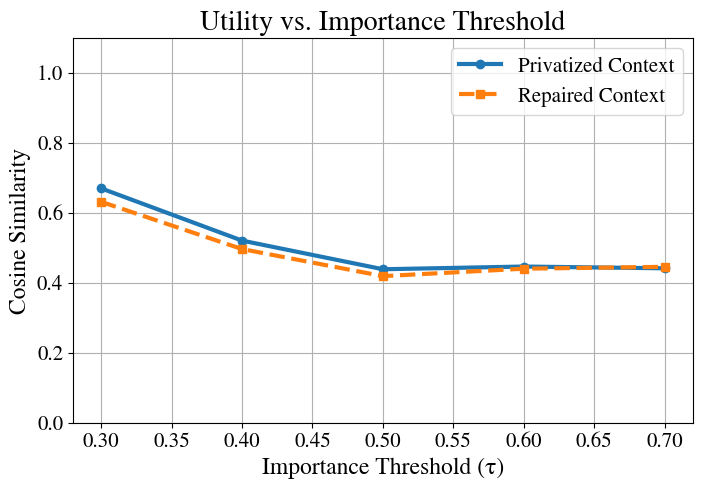

In [ ]:
# Extract tau values from the 'dataframe' column
df_all_results_combined['tau'] = df_all_results_combined['dataframe'].apply(lambda x: float(x.split('_')[-1]))

# Aggregate results by tau and context type, calculating mean and std deviation
df_aggregated_cosine_rounds = df_all_results_combined.groupby('tau').agg(
    mean_cosine_privatized=('cosine_privatized', 'mean'),
    std_cosine_privatized=('cosine_privatized', 'std'),
    mean_cosine_repaired=('cosine_repaired', 'mean'),
    std_cosine_repaired=('cosine_repaired', 'std')
).reset_index()

# Sort by tau value to ensure correct line plotting
df_aggregated_cosine_rounds = df_aggregated_cosine_rounds.sort_values('tau')

# Create the plot with the specified figure size
plt.figure(figsize=(8, 5))

# Plot mean Cosine Similarity for Privatized Context without error bars and updated style
plt.errorbar(
    df_aggregated_cosine_rounds['tau'],
    df_aggregated_cosine_rounds['mean_cosine_privatized'],
    label='Privatized Context',
    marker='o',
    linestyle='-', # Use a solid line
    linewidth=3
)

# Plot mean Cosine Similarity for Repaired Context without error bars and updated style
plt.errorbar(
    df_aggregated_cosine_rounds['tau'],
    df_aggregated_cosine_rounds['mean_cosine_repaired'],
    label='Repaired Context',
    marker='s', # Changed marker to 's' for square
    linestyle='--', # Use a dashed line for distinction
    linewidth=3
)

# --- Baselines ---
# Add any baselines here if needed, similar to the example provided in the user's query.
# For example:
# plt.axhline(y=some_baseline_value, color='red', linestyle=':', linewidth=3, label='Baseline')


# --- Style ---
plt.title('Utility vs. Importance Threshold', fontsize=20)
plt.xlabel('Importance Threshold (τ)', fontsize=17) # Added tau symbol
plt.ylabel('Cosine Similarity', fontsize=17)
plt.ylim(0, 1.1) # Set y-axis limit
plt.grid(True)
plt.legend(fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

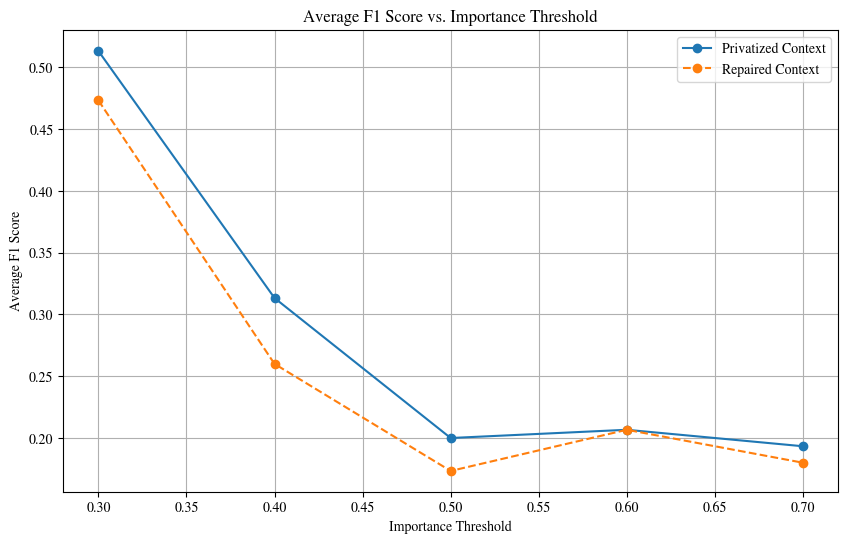

In [ ]:
# Extract tau values from the 'dataframe' column (if not already done in df_all_results_combined)
if 'tau' not in df_all_results_combined.columns:
    df_all_results_combined['tau'] = df_all_results_combined['dataframe'].apply(lambda x: float(x.split('_')[-1]))

# Aggregate results by tau and context type, calculating mean and std deviation for F1
df_aggregated_f1_rounds = df_all_results_combined.groupby('tau').agg(
    mean_f1_privatized=('f1_privatized', 'mean'),
    std_f1_privatized=('f1_privatized', 'std'),
    mean_f1_repaired=('f1_repaired', 'mean'),
    std_f1_repaired=('f1_repaired', 'std')
).reset_index()

# Sort by tau value to ensure correct line plotting
df_aggregated_f1_rounds = df_aggregated_f1_rounds.sort_values('tau')

# Create the plot
plt.figure(figsize=(10, 6))

# Plot mean F1 for Privatized Context without error bars
plt.errorbar(
    df_aggregated_f1_rounds['tau'],
    df_aggregated_f1_rounds['mean_f1_privatized'],
    label='Privatized Context',
    marker='o',
    linestyle='-' # Use a solid line
)

# Plot mean F1 for Repaired Context without error bars
plt.errorbar(
    df_aggregated_f1_rounds['tau'],
    df_aggregated_f1_rounds['mean_f1_repaired'],
    label='Repaired Context',
    marker='o',
    linestyle='--' # Use a dashed line for distinction
)


plt.title('Average F1 Score vs. Importance Threshold')
plt.xlabel('Importance Threshold')
plt.ylabel('Average F1 Score')
plt.grid(True)
plt.legend()
plt.show()

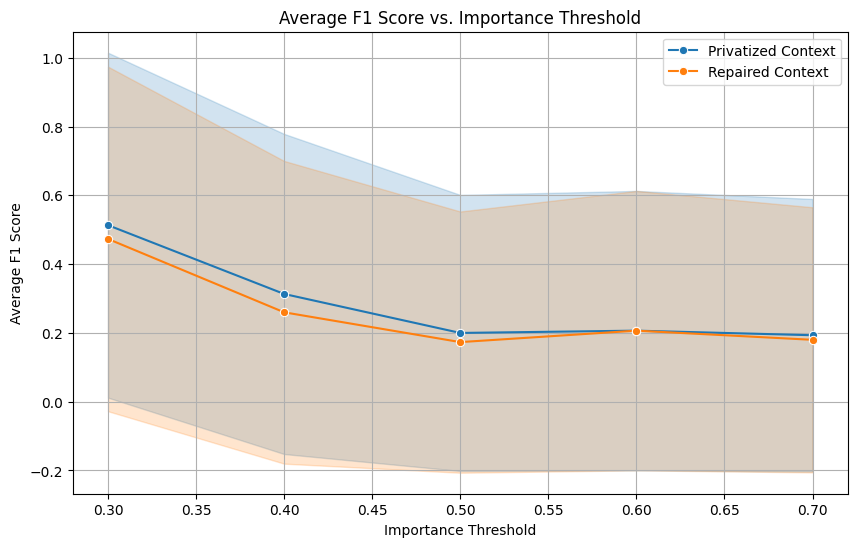

In [ ]:
# Extract tau values from the 'dataframe' column (if not already done in df_all_results_combined)
if 'tau' not in df_all_results_combined.columns:
    df_all_results_combined['tau'] = df_all_results_combined['dataframe'].apply(lambda x: float(x.split('_')[-1]))

# Create the plot for F1 scores with shaded standard deviation
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_all_results_combined, x='tau', y='f1_privatized', label='Privatized Context', marker='o', errorbar='sd')
sns.lineplot(data=df_all_results_combined, x='tau', y='f1_repaired', label='Repaired Context', marker='o', errorbar='sd')

plt.title('Average F1 Score vs. Importance Threshold')
plt.xlabel('Importance Threshold')
plt.ylabel('Average F1 Score')
plt.grid(True)
plt.legend()
plt.show()

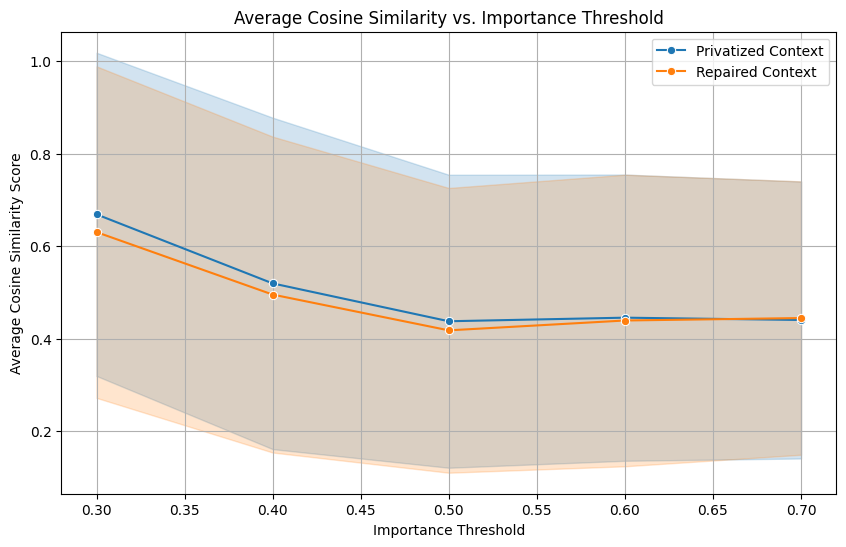

In [ ]:
# Extract tau values from the 'dataframe' column (if not already done in df_all_results_combined)
if 'tau' not in df_all_results_combined.columns:
    df_all_results_combined['tau'] = df_all_results_combined['dataframe'].apply(lambda x: float(x.split('_')[-1]))

# Create the plot for Cosine Similarity with shaded standard deviation
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_all_results_combined, x='tau', y='cosine_privatized', label='Privatized Context', marker='o', errorbar='sd')
sns.lineplot(data=df_all_results_combined, x='tau', y='cosine_repaired', label='Repaired Context', marker='o', errorbar='sd')

plt.title('Average Cosine Similarity vs. Importance Threshold')
plt.xlabel('Importance Threshold')
plt.ylabel('Average Cosine Similarity Score')
plt.grid(True)
plt.legend()
plt.show()

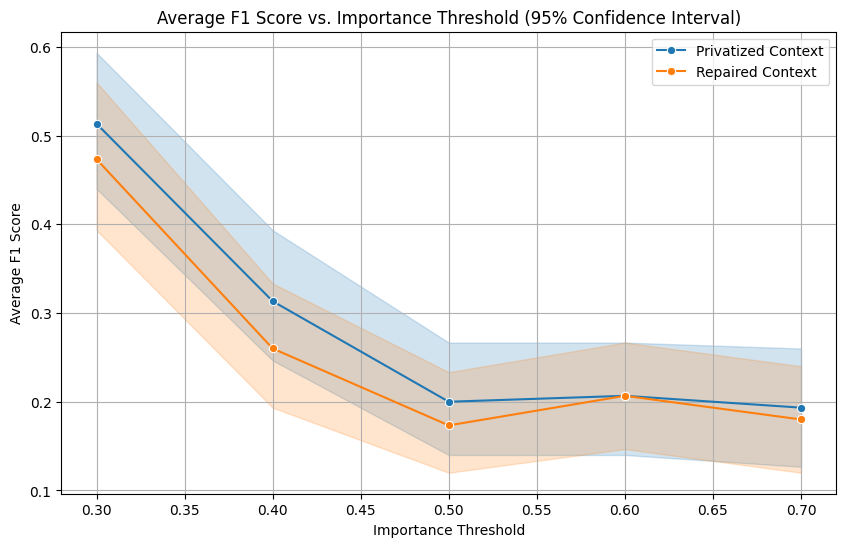

In [ ]:
# Extract tau values from the 'dataframe' column (if not already done in df_all_results_combined)
if 'tau' not in df_all_results_combined.columns:
    df_all_results_combined['tau'] = df_all_results_combined['dataframe'].apply(lambda x: float(x.split('_')[-1]))

# Create the plot for F1 scores with confidence intervals
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_all_results_combined, x='tau', y='f1_privatized', label='Privatized Context', marker='o', errorbar=('ci', 95))
sns.lineplot(data=df_all_results_combined, x='tau', y='f1_repaired', label='Repaired Context', marker='o', errorbar=('ci', 95))

plt.title('Average F1 Score vs. Importance Threshold (95% Confidence Interval)')
plt.xlabel('Importance Threshold')
plt.ylabel('Average F1 Score')
plt.grid(True)
plt.legend()
plt.show()

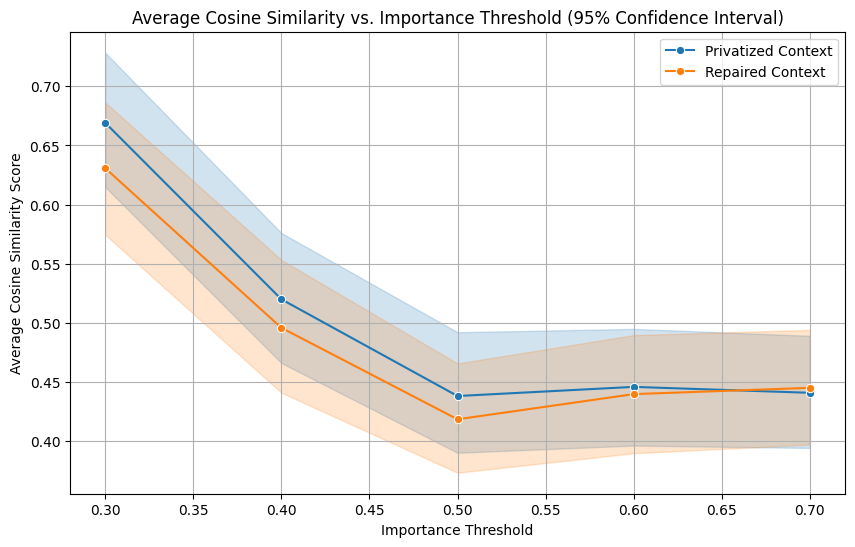

In [ ]:
# Extract tau values from the 'dataframe' column (if not already done in df_all_results_combined)
if 'tau' not in df_all_results_combined.columns:
    df_all_results_combined['tau'] = df_all_results_combined['dataframe'].apply(lambda x: float(x.split('_')[-1]))

# Create the plot for Cosine Similarity with confidence intervals
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_all_results_combined, x='tau', y='cosine_privatized', label='Privatized Context', marker='o', errorbar=('ci', 95))
sns.lineplot(data=df_all_results_combined, x='tau', y='cosine_repaired', label='Repaired Context', marker='o', errorbar=('ci', 95))

plt.title('Average Cosine Similarity vs. Importance Threshold (95% Confidence Interval)')
plt.xlabel('Importance Threshold')
plt.ylabel('Average Cosine Similarity Score')
plt.grid(True)
plt.legend()
plt.show()